In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, MaxPooling2D ,Conv2D, Flatten, GlobalMaxPool2D
from tensorflow.keras.applications import Xception, mobilenet_v3, vgg16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import layers

In [13]:
img_width, img_height = 299,299
batch_size = 32
num_epochs = 50

In [14]:
baseDir = '/kaggle/input/eyepacs-airogs-light/release-crop/release-crop/'
testDir = baseDir + 'test'
trainDir = baseDir + 'train'
validDir = baseDir + 'validation'

In [15]:
val_datagen = ImageDataGenerator(rescale = 1. / 255)
train_datagen = ImageDataGenerator(#rotation_range=90,
                                    #brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     #validation_split=0.15,
                                    #preprocessing_function=preprocess_input,
                                    zoom_range=0.15,
                                    fill_mode="constant",
                                    cval=0.1,
                                    rescale = 1. / 255)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [16]:
train_generator = train_datagen.flow_from_directory(
    directory=trainDir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = True
)

validation_generator = val_datagen.flow_from_directory(
    directory=validDir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary',
    shuffle = False
)

test_generator =  test_datagen.flow_from_directory(
    testDir,
    batch_size=batch_size,
    class_mode='binary',
    target_size=(img_width, img_height),
    shuffle = False
)

Found 5000 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [17]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              min_lr=0)

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience = 15,
                               mode='auto',
                               min_delta = 0.001)

base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top=False,
                                                            input_shape=(img_width, img_height, 3), 
                                                            classifier_activation='sigmoid')
base_model.trainable = True
#for layer in base_model.layers[:108]:
#   layer.trainable = False
    
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
    

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[lr_reduce, early_stopping],
    verbose = 2
)

Epoch 1/50
157/157 - 170s - loss: 0.5673 - accuracy: 0.7024 - val_loss: 2.2631 - val_accuracy: 0.7037 - lr: 0.0010 - 170s/epoch - 1s/step
Epoch 2/50
157/157 - 109s - loss: 0.4444 - accuracy: 0.7948 - val_loss: 0.3417 - val_accuracy: 0.8944 - lr: 0.0010 - 109s/epoch - 696ms/step
Epoch 3/50
157/157 - 108s - loss: 0.3923 - accuracy: 0.8228 - val_loss: 0.5203 - val_accuracy: 0.8426 - lr: 0.0010 - 108s/epoch - 687ms/step
Epoch 4/50
157/157 - 109s - loss: 0.3718 - accuracy: 0.8276 - val_loss: 0.2789 - val_accuracy: 0.8833 - lr: 0.0010 - 109s/epoch - 696ms/step
Epoch 5/50
157/157 - 109s - loss: 0.3861 - accuracy: 0.8286 - val_loss: 0.2830 - val_accuracy: 0.9074 - lr: 0.0010 - 109s/epoch - 692ms/step
Epoch 6/50
157/157 - 109s - loss: 0.3675 - accuracy: 0.8374 - val_loss: 0.3558 - val_accuracy: 0.8611 - lr: 0.0010 - 109s/epoch - 691ms/step
Epoch 7/50
157/157 - 109s - loss: 0.3427 - accuracy: 0.8466 - val_loss: 0.2229 - val_accuracy: 0.9167 - lr: 0.0010 - 109s/epoch - 696ms/step
Epoch 8/50
157/1

32/32 - 11s - loss: 0.1733 - accuracy: 0.9350 - 11s/epoch - 341ms/step


[0.17328566312789917, 0.9350000023841858]

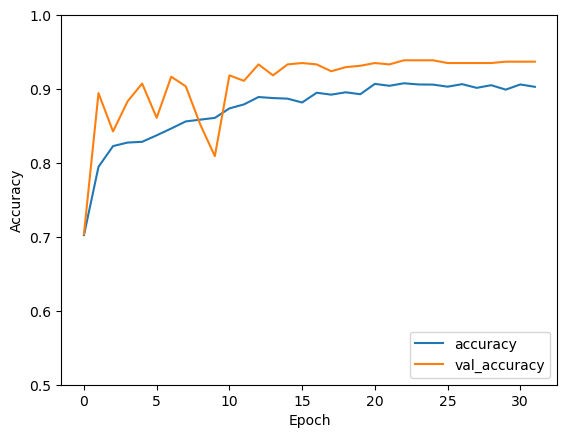

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

model.evaluate(test_generator, verbose=2)